# 3.3 Limpieza y estructuración del dataset

Una vez extraídos los datos multimodales por vídeo y por segmento, se procedió a un proceso de limpieza, integración y reestructuración del dataset, con el objetivo de preparar los datos para su análisis posterior.

Primeramente indicamos las carpetas de trabajo.

⚠️ Requisitos importantes antes de ejecutar este notebook
Este notebook está diseñado para ejecutarse en Google Colab.
Requiere el uso de una GPU T4 y una correcta configuración de rutas para funcionar correctamente.

1. Tipo de entorno
Ve a Entorno de ejecución > Cambiar tipo de entorno y selecciona GPU T4
Comprueba que se ha asignado una GPU T4 ejecutando:
2. Instalación de librerías
Tras la instalación de las librerías necesarias, es obligatorio reiniciar el entorno antes de continuar con la ejecución.

Ve a Entorno de ejecución > Reiniciar entorno de ejecución

3. Configuración de rutas
Antes de ejecutar las celdas principales, configura correctamente las siguientes rutas:

folder_path: Carpeta de trabajo principal.

json_path: Carpeta donde se han descargado los json, a meddida que se vayan analizando los videos.

In [11]:
import os
import json
import pandas as pd
import shap

from google.colab import drive
drive.mount('/content/drive')

#carpeta de trabajo principal
folder_path = "/content/drive/MyDrive/Analisis_Multimodal_Comunicacion_TFM/data/folder_path"
#carpeta donde descargue los json con la informacion de los videos analizados.
json_path = "/content/drive/MyDrive/Analisis_Multimodal_Comunicacion_TFM/data/json_path"

os.makedirs(folder_path, exist_ok=True)
os.makedirs(json_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Unificación de archivos JSON

Cada grupo de vídeos procesado generó un archivo individual en formato .json, que contenía la información estructurada de cada vídeo y sus respectivos segmentos. Estos archivos fueron combinados en un único fichero llamado features_videos_ted.json, almacenado en la carpeta de trabajo principal.

Este fichero consolidado agrupa todos los vídeos procesados, cada uno identificado por su video_id y acompañado de metadatos generales (idioma, duración, categoría, texto completo) y una lista de segmentos analizados.

In [ ]:
#CONVINAR ARCHIVOS


features_videos_ted =os.path.join(folder_path, "features_videos_ted.json")

# Diccionario final que contendrá todos los videos
combined_data = {}
files=0
# Recorrer todos los archivos en la carpeta
for filename in os.listdir(json_path):
    if filename.endswith(".json"):
        filepath = os.path.join(json_path, filename)

        with open(filepath, "r", encoding="utf-8") as f:
            try:
                data = json.load(f)

                combined_data.update(data)
                files+=1
            except Exception as e:
                print(f"❌ Error leyendo {filename}: {e}")

# Guardar el JSON combinado

with open(features_videos_ted, "w", encoding="utf-8") as f:
    json.dump(combined_data, f, ensure_ascii=False, indent=2)

print(f"✅ {files} Archivos combinados en {features_videos_ted}")

✅ 0 Archivos combinados en /content/drive/MyDrive/TFM_Analisis_Multimodal_Comunicacion/data/folder_path/features_videos_ted.json


## A partir del JSON unificado se generaron dos datasets en formato tabular:

### a) Dataset a nivel de vídeo

Se creó un primer DataFrame en el que cada fila representa un vídeo. Para simplificar su estructura, se eliminó la columna segmentos, que fue tratada por separado. Este dataset, denominado df_videos_analizados.csv, contiene información general sobre cada vídeo, como:

video_id: identificador único.

link: enlace original.

tipo_comunicador: clase binaria (0 = baja calidad, 1 = alta calidad).

grupo: lote de procesamiento.

duracion_video: duración total del vídeo.

texto_completo: transcripción completa del discurso.

idioma: idioma detectado.

Obtenemos un total de 2669 videos, de los cuales 1349 son tipo_comunicador "0" (mal comunicador) y 1320 son tipo_comunicador "1! (buen comunicador). Todos sin nulos en estos valores. La duración de estos videos es desde los 60 segundos a los 340 minutos con una media de 12 miutos de duración. El idioma principal es el inglés con 2540 videos.

la diferencia entre los 2669 videos que hemos analizado y los 2770 videos del listado inicial que pretendíamoa analizar, se debe a errores en la descarga y analisis de estos.

In [12]:
#LEER EL JSON Y CONVERTIRLO A PANDAS
features_videos_ted =os.path.join(folder_path, "features_videos_ted.json")
# Leer JSON y girar (trasponer) para que los video_id sean filas
df_videos = pd.read_json(features_videos_ted).T.reset_index(drop=True)
#Eliminamos la columna segmentos, los expandiremos y los trataremos en otro dataset
df_videos = df_videos.drop(columns=['segmentos'])
# Guardar el CSV
df_videos.to_csv(os.path.join(folder_path, "df_videos_analizados.csv"), index=False)
print("✅ Dataset 'df_videos' guardado como 'df_videos_analizados.csv'.")
print(df_videos.head())
print(df_videos.info())

/tmp/ipython-input-96656702.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_videos = pd.read_json(features_videos_ted).T.reset_index(drop=True)
/tmp/ipython-input-96656702.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df_videos = pd.read_json(features_videos_ted).T.reset_index(drop=True)
/tmp/ipython-input-96656702.py:4: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime s

✅ Dataset 'df_videos' guardado como 'df_videos_analizados.csv'.
  video_id                                               link  \
0       66  https://ted.com/talks/sir_ken_robinson_do_scho...   
1    24447  https://ted.com/talks/annie_bosler_and_don_gre...   
2     2005  https://ted.com/talks/andrew_solomon_how_the_w...   
3      129  https://ted.com/talks/blaise_aguera_y_arcas_ho...   
4     2305  https://ted.com/talks/john_green_the_nerd_s_gu...   

  tipo_comunicador grupo duracion_video  \
0                1     1    1151.849062   
1                1     1     275.272562   
2                1     1    1214.008875   
3                1     1     436.604812   
4                1     1       1081.005   

                                      texto_completo idioma  
0   Good morning. How are you? It's been great, h...     en  
1   Mastering any physical skill, be it performin...     en  
2   As a student of adversity, I've been struck o...     en  
3   What I'm going to show you first a

In [13]:
import numpy as np
df_videos['duracion_video'] = pd.to_numeric(df_videos['duracion_video'], errors='coerce')
df_videos.describe()

,duracion_video
count,2669.000000
mean,711.273003
std,618.133724
min,60.836312
25%,323.407562
50%,665.925062
75%,937.946875
max,20403.613500


In [14]:
df_videos.describe(exclude=np.number)

,video_id,link,tipo_comunicador,grupo,texto_completo,idioma
count,2669,2669,2669,2669,2669,2669
unique,2669,2669,2,100,2668,23
top,2386,https://ted.com/talks/year_in_ideas_2015,0,1,I will never forget the day my younger brothe...,en
freq,1,1,1349,28,2,2540


In [15]:
df_videos['tipo_comunicador'].value_counts()

,count
tipo_comunicador,
0,1349
1,1320


### b) Dataset a nivel de segmento

En paralelo, se creó un segundo DataFrame con una fila por cada segmento, extrayendo y reorganizando todas las variables relevantes desde el JSON original. Esta transformación permitió normalizar los datos para el análisis cuantitativo y el entrenamiento de modelos.

Cada fila del nuevo dataset contiene una combinación de información textual, acústica y visual por segmento, incluyendo:

Identificadores (video_id, seg_id)

Información textual (texto, pmm)

Audio (rms_mean, zcr_mean, tipo, emocion)

Datos visuales (expresiones, postura, manos, inclinaciones)

Marcadores temporales (inicio, fin, duracion)

In [ ]:
#Crear un dataframe con una linea por segmento, para posteriormente sacar características globales
features_videos_ted =os.path.join(folder_path, "features_videos_ted.json")

# Leer JSON modificado
with open(features_videos_ted, "r", encoding="utf-8") as f:
    data = json.load(f)

# Crear lista de filas
filas = []
for video_id, video in data.items():
    for seg in video["segmentos"]:
        audio = seg["audio"]
        video_info = seg.get("video", {})
        analisis = video_info.get("analisis", {})

        # Extraer detalle de manos
        manos = { "Left": {"x": None, "y": None}, "Right": {"x": None, "y": None} }
        for mano in analisis.get("detalle_manos", []):
            tipo = mano.get("tipo")
            pos = mano.get("posicion_media", {})
            if tipo in manos:
                manos[tipo]["x"] = pos.get("x")
                manos[tipo]["y"] = pos.get("y")

        fila = {
            "video_id": video_id,
            "seg_id": seg["seg_id"],
            "texto": audio.get("texto", ""),
            "inicio": audio.get("inicio", None),
            "fin": audio.get("fin", None),
            "duracion": audio.get("duracion", None),
            "pausa_anterior": audio.get("pausa_anterior", None),
            "rms_mean": audio.get("rms_mean", None),
            "zcr_mean": audio.get("zcr_mean", None),
            "tipo_audio": audio.get("tipo", None),
            "pmm": audio.get("pmm", None),
            "emocion_audio": audio.get("emocion", None),
            # Información del video
            "t_central": video_info.get("t_central", None),
            "frame_id": video_info.get("frame_id", None),
            "cara_detectada": analisis.get("cara_detectada", False),
            "yaw": analisis.get("inclinacion_cabeza", {}).get("yaw", None),
            "pitch": analisis.get("inclinacion_cabeza", {}).get("pitch", None),
            "roll": analisis.get("inclinacion_cabeza", {}).get("roll", None),
            "boca_abierta": analisis.get("boca_abierta", None),
            "sonrisa": analisis.get("sonrisa", None),
            "sonrisa_detectada": analisis.get("sonrisa_detectada", False),
            "ceño_fruncido": analisis.get("ceño_fruncido", None),
            "ceño_detectado": analisis.get("ceño_detectado", False),
            "ojos_abiertos": analisis.get("ojos_abiertos", None),
            "asimetria_labios": analisis.get("asimetria_labios", None),
            "tension_facial": analisis.get("tension_facial", None),
            "estado_emocional": analisis.get("estado_emocional", "desconocido"),
            "apertura_brazos": analisis.get("apertura_brazos", None),
            "inclinacion_torso": analisis.get("inclinacion_torso", None),
            "manos_visibles": analisis.get("manos_visibles", None),
            "mano_izq_x": manos["Left"]["x"],
            "mano_izq_y": manos["Left"]["y"],
            "mano_der_x": manos["Right"]["x"],
            "mano_der_y": manos["Right"]["y"],
        }
        filas.append(fila)

df_segmentos = pd.DataFrame(filas)
print(df_segmentos.head())


  video_id  seg_id                            texto  inicio    fin  duracion  \
0       66       1                                     0.00   5.02      5.02   
1       66       2              Good  morning.  How    5.02   7.36      2.34   
2       66       3                   How  are  you?    7.36   8.61      1.25   
3       66       4                             It's    8.61   9.66      1.05   
4       66       5  It's  been  great,  hasn't  it?    9.66  11.90      2.24   

   pausa_anterior  rms_mean  zcr_mean tipo_audio  ...  asimetria_labios  \
0           0.000  0.060780  0.109712      Pausa  ...               NaN   
1           1.696  0.029090  0.139932      Habla  ...          0.009879   
2           0.320  0.041850  0.168933      Habla  ...               NaN   
3           0.544  0.022007  0.217170      Habla  ...               NaN   
4           0.000  0.042335  0.156511      Habla  ...               NaN   

  tension_facial  estado_emocional  apertura_brazos  inclinacion_tor

Eliminamos el tipo de segmento pausa, reordenamos, reasignamos numero de segmento y recalculamos la pausa antes de cada segmento.

In [ ]:
# 1. Eliminar filas donde tipo_audio == "Pausa"
df_segmentos = df_segmentos[df_segmentos["tipo_audio"] != "Pausa"].copy()

# 2. Ordenar por video_id y seg_id (o por inicio si es más fiable)
df_segmentos = df_segmentos.sort_values(by=["video_id", "seg_id"]).copy()

# 3. Reasignar seg_id por cada video_id
df_segmentos["seg_id"] = df_segmentos.groupby("video_id").cumcount() + 1

def recalcular_pausa(grupo):
    # Ordenar por seg_id para asegurar secuencia correcta
    grupo = grupo.sort_values(by="seg_id").copy()

    nuevas_pausas = []
    fin_anterior = None

    for _, fila in grupo.iterrows():
        if fin_anterior is None:
            # Primer segmento del video
            nueva_pausa = fila["pausa_anterior"] + fila["inicio"]
        else:
            # Diferencia con el segmento anterior
            nueva_pausa = fila["pausa_anterior"] + (fila["inicio"] - fin_anterior)


        nuevas_pausas.append(nueva_pausa)
        fin_anterior = fila["fin"]

    grupo["pausa_anterior"] = nuevas_pausas
    return grupo

# 4. Aplicar por cada video_id
df_segmentos= df_segmentos.groupby("video_id", group_keys=False).apply(recalcular_pausa)

# 5. Eliminar columna tipo_audio
if "tipo_audio" in df_segmentos.columns:
    df_segmentos= df_segmentos.drop(columns=["tipo_audio"])

# 6. Resetear índice
df_segmentos=df_segmentos.reset_index(drop=True)

/tmp/ipython-input-1903990903.py:33: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_segmentos= df_segmentos.groupby("video_id", group_keys=False).apply(recalcular_pausa)


Información del dataframe.


In [ ]:
print(df_segmentos.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860632 entries, 0 to 860631
Data columns (total 33 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   video_id           860632 non-null  object 
 1   seg_id             860632 non-null  int64  
 2   texto              860632 non-null  object 
 3   inicio             860632 non-null  float64
 4   fin                860632 non-null  float64
 5   duracion           860632 non-null  float64
 6   pausa_anterior     860632 non-null  float64
 7   rms_mean           860632 non-null  float64
 8   zcr_mean           860632 non-null  float64
 9   pmm                860632 non-null  float64
 10  emocion_audio      860632 non-null  object 
 11  t_central          860632 non-null  float64
 12  frame_id           853867 non-null  float64
 13  cara_detectada     860632 non-null  bool   
 14  yaw                440091 non-null  float64
 15  pitch              440091 non-null  float64
 16  ro

Observamos que en muchos de los datos capturados del video no tenemos datos. como vemos depende de que no se ha detectado la cara, puede ser por el tipo de grabación.

En cuanto a la postura de las manos, por un error en la definición del código lo la el dato es referido al la posición en la imagen y no con respecto a la cara o algu que pueda ser comparado, por lo tanto vamos a quitar del analisis esta parte y nos fijaremos para detectar gesticulación en la apertura de brazos.

El "estado emocional" del viedeo está calculado a partir de factores como "sonrisa", "tension_facial", "ceño fruncido" eliminaremos estos y nos quedaremos con los datos puros.

Vamos a eliminar tambien "ceño_detectado" y "sonrisa_detectada", ambos tipo bool, ya que su información la tenemos tambien en "ceño_fruncido" y "sonrisa".

In [ ]:
df_segmentos.drop(columns=["manos_visibles", "mano_izq_x","mano_izq_y","mano_der_x","mano_der_y","ceño_detectado","sonrisa_detectada","estado_emocional"], inplace=True)

In [ ]:
# Mostrar todas las columnas
pd.set_option("display.max_columns", None)
df_segmentos.describe()

,seg_id,inicio,fin,duracion,pausa_anterior,rms_mean,zcr_mean,pmm,t_central,frame_id,yaw,pitch,roll,boca_abierta,sonrisa,ceño_fruncido,ojos_abiertos,asimetria_labios,tension_facial,apertura_brazos,inclinacion_torso
count,860632.000000,860632.000000,860632.000000,860632.000000,860632.000000,860632.000000,860632.000000,860632.000000,860632.000000,853867.000000,440091.000000,440091.000000,440091.000000,440091.000000,440091.000000,440091.000000,440091.000000,440091.000000,440091.000000,693403.000000,693403.000000
mean,276.032474,586.492268,588.619044,2.126776,0.491876,0.072590,0.144523,190.511336,587.555658,15988.747688,1.118658,88.281221,-1.234146,0.063820,330.371584,1.263227,0.074682,0.008953,2.004129,44.752091,137.963473
std,409.170775,1116.225564,1116.300022,2.077637,1.854948,0.036907,0.047235,77.028371,1116.262308,33252.524500,30.254143,17.602925,8.361898,0.072353,2295.423485,0.060524,0.036206,0.010634,0.674619,38.520012,60.130192
min,1.000000,0.000000,1.060000,1.020000,0.000000,0.000041,0.000151,0.577256,0.530000,12.000000,-177.587365,-179.854081,-165.917847,0.000000,0.008698,0.000402,0.000257,0.000000,0.000000,0.170440,0.021643
25%,84.000000,179.870000,181.980000,1.250000,0.000000,0.044201,0.111053,137.404580,180.930000,4589.000000,-18.620365,79.127354,-5.170189,0.004214,5.554187,1.244587,0.047441,0.002655,2.000000,20.805253,136.091201
50%,188.000000,388.670000,390.750000,1.670000,0.288000,0.070389,0.138990,183.206107,389.710000,10057.000000,0.641750,88.392414,-1.063907,0.040004,13.568246,1.268919,0.072454,0.006103,2.000000,28.691450,170.067240
75%,338.000000,674.240000,676.380000,2.430000,0.672000,0.098135,0.171862,235.294118,675.310000,17696.000000,20.598929,97.311758,2.751472,0.102513,127.568357,1.291528,0.099184,0.011846,2.000000,52.358765,175.657539
max,6589.000000,20386.500000,20403.580000,299.460000,448.862000,0.449975,0.615118,4981.132075,20395.040000,611239.000000,176.351474,179.911040,179.030060,0.876542,183868.396846,1.593396,0.348697,0.389948,3.000000,179.845850,179.970154


In [ ]:
df_segmentos.describe(include=[object, bool])

,video_id,texto,emocion_audio,cara_detectada
count,860632,860632,860632,860632
unique,2668,834962,8,2
top,5dVcn8NjbwY,I,fearful,True
freq,6589,667,482557,440091


## Estudio de outlaiers

Utilizamos una función para visualizarlos

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
from pandas.api.types import is_object_dtype, is_bool_dtype, is_numeric_dtype

def histogram_boxplot(data, xlabel=None, title=None, font_scale=2, figsize=(5,4), bins=None):
    """ Boxplot and histogram combined
    data: 1-d data array
    xlabel: xlabel
    title: title
    font_scale: the scale of the font (default 2)
    figsize: size of fig (default (5,4))
    bins: number of bins (default None / auto)
    """
    # Definir tamaño letra
    sns.set(font_scale=font_scale)
    # Crear ventana para los subgráficos
    f2, (ax_box2, ax_hist2) = plt.subplots(
        2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=figsize
    )
    # Crear boxplot
    sns.boxplot(x=data, ax=ax_box2)
    # Crear histograma
    sns.histplot(x=data, ax=ax_hist2, bins=bins) if bins else sns.histplot(x=data, ax=ax_hist2)
    # Pintar una línea con la media
    ax_hist2.axvline(np.mean(data), color='g', linestyle='-')
    # Pintar una línea con la mediana
    ax_hist2.axvline(np.median(data), color='y', linestyle='--')
    # Asignar título y nombre de eje si tal
    if xlabel:
        ax_hist2.set(xlabel=xlabel)
    if title:
        ax_box2.set(title=title, xlabel="")
    # Mostrar gráfico
    plt.show()

def cat_plot(col):
    """ Gráfico de barras para variables categóricas o booleanas """
    if is_object_dtype(col) or is_bool_dtype(col):
        fig = px.bar(col.value_counts())
        return fig

def plot(col):
    """ Detecta si la columna es categórica o numérica y aplica el gráfico adecuado """
    if is_numeric_dtype(col):
        print('Cont →', col.name)
        histogram_boxplot(col.dropna(), xlabel=col.name, title='Distribución continua')
    else:
        print('Cat →', col.name)
        fig = cat_plot(col.dropna())
        if fig:
            fig.show()

Cont → duracion


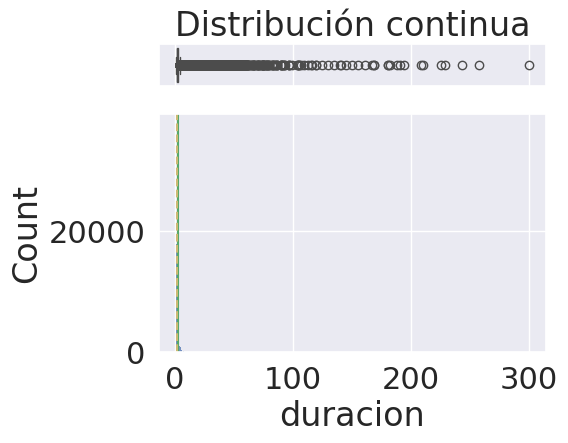

Cont → pausa_anterior


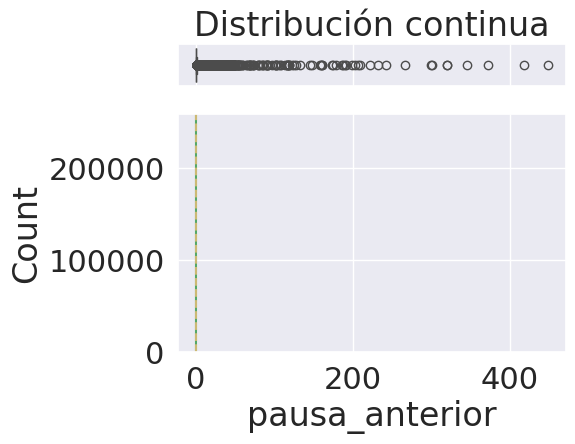

Cont → rms_mean


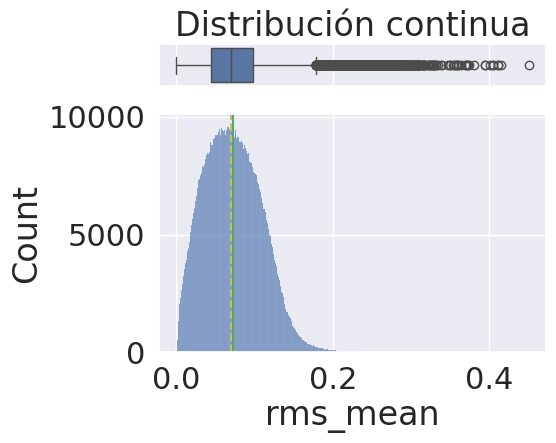

Cont → zcr_mean


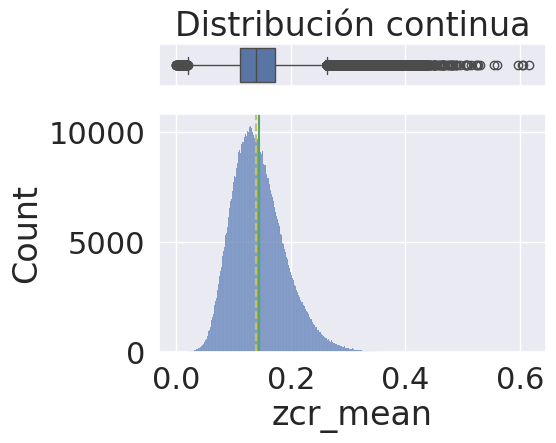

Cont → pmm


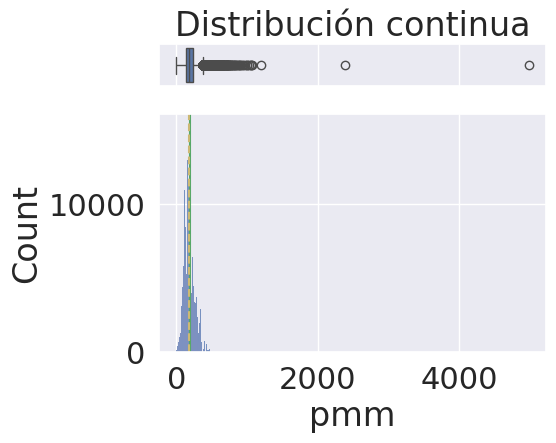

Cat → emocion_audio


Cont → cara_detectada


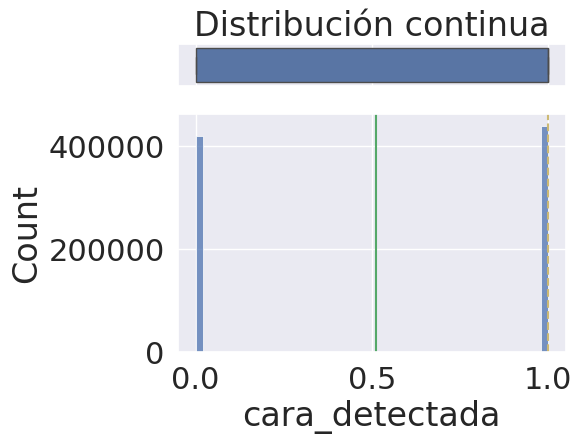

Cont → yaw


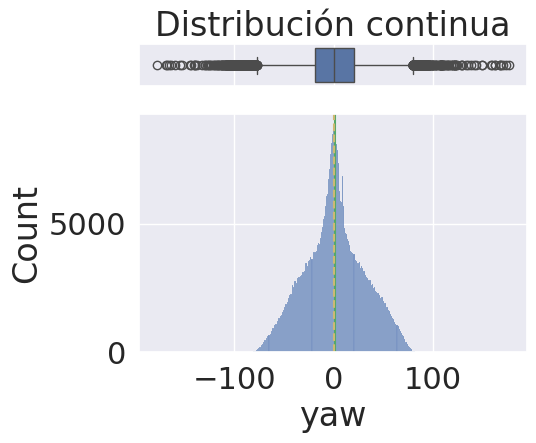

Cont → pitch


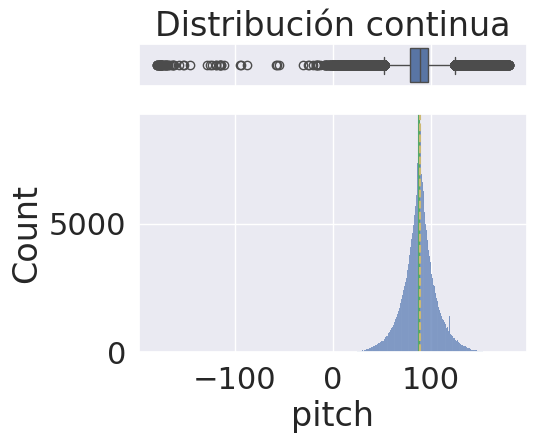

Cont → roll


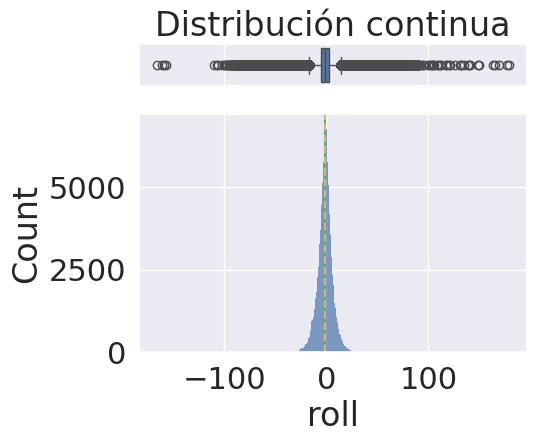

Cont → boca_abierta


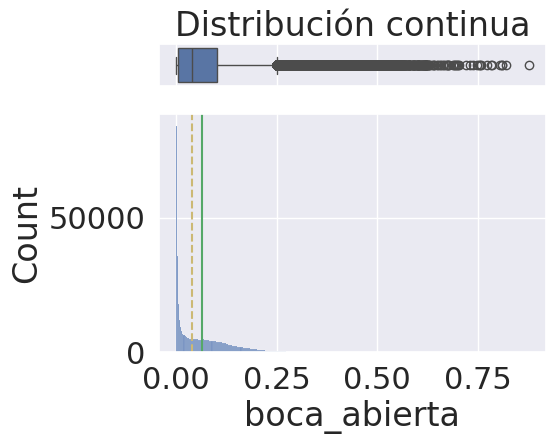

Cont → sonrisa


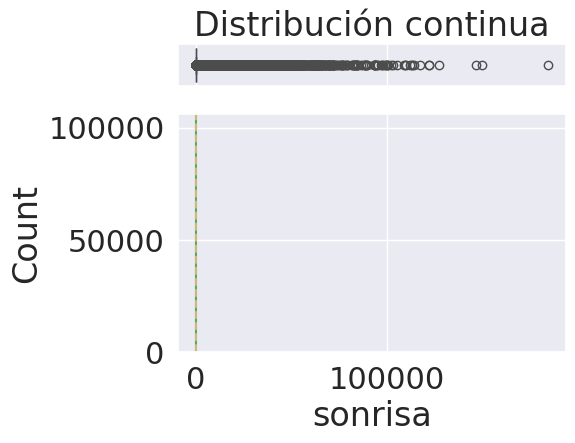

Cont → ceño_fruncido


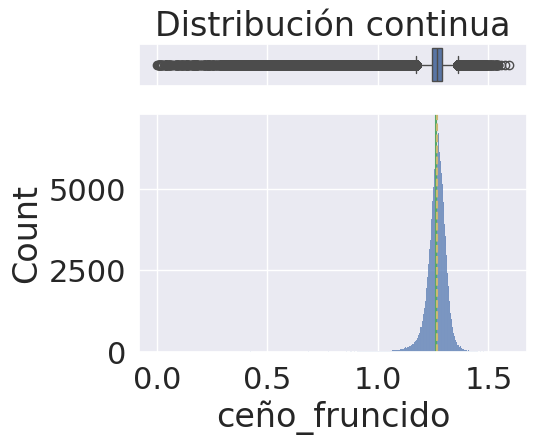

Cont → ojos_abiertos


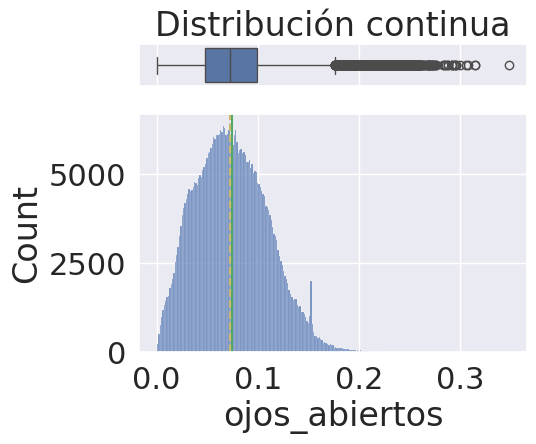

Cont → asimetria_labios


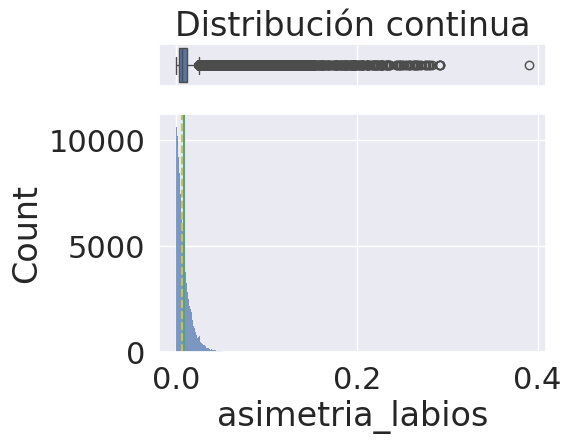

Cont → tension_facial


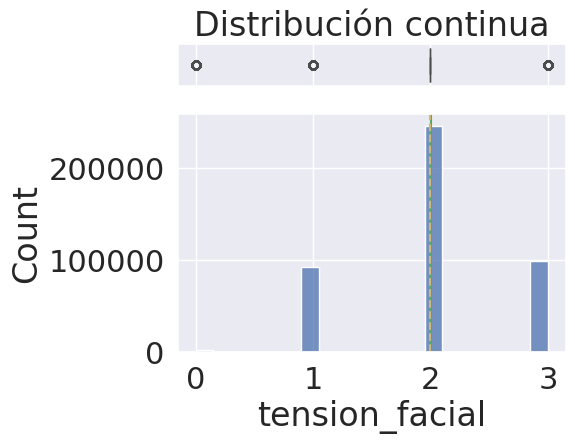

Cont → apertura_brazos


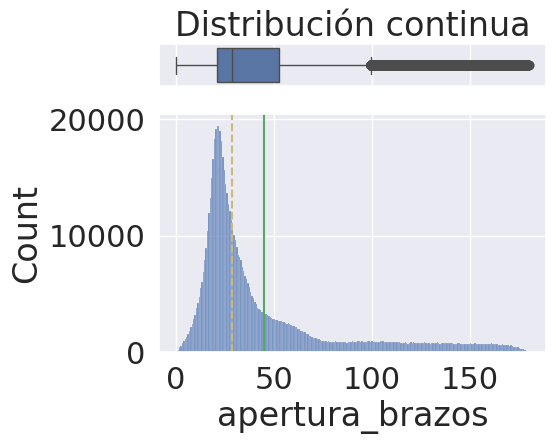

Cont → inclinacion_torso


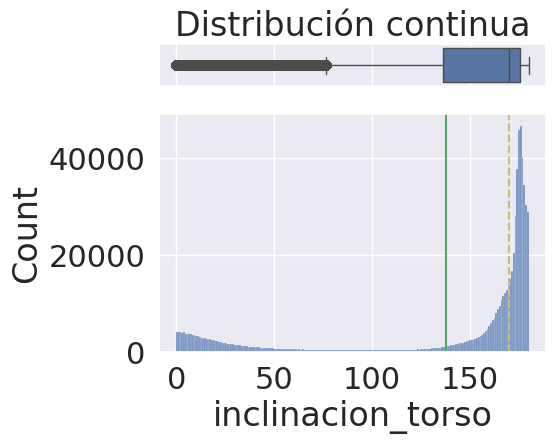

In [ ]:
cols =['duracion',
       'pausa_anterior', 'rms_mean', 'zcr_mean', 'pmm', 'emocion_audio', 'cara_detectada', 'yaw', 'pitch', 'roll',
       'boca_abierta', 'sonrisa', 'ceño_fruncido', 'ojos_abiertos',
       'asimetria_labios', 'tension_facial', 'apertura_brazos',
       'inclinacion_torso']
for col in cols:
    plot(df_segmentos[col])

Hay presencia de outlaiers en todas las mediciones, como mi proceso de trabajo va a ser obter meedias, medianas, cuartiles de estos datos por partes del discurso, en ese momento ya aplano los datos, no necesito hacerlo ahora.

En el caso del "pmm" palabras por minuto hay dos datos que se distancian mucho.

In [ ]:
df_segmentos.nlargest(2, 'pmm')

,video_id,seg_id,texto,inicio,fin,duracion,pausa_anterior,rms_mean,zcr_mean,pmm,emocion_audio,t_central,frame_id,cara_detectada,yaw,pitch,roll,boca_abierta,sonrisa,ceño_fruncido,ojos_abiertos,asimetria_labios,tension_facial,apertura_brazos,inclinacion_torso
376970,31628,174,"it, get it, get it, get it, get it, g...",436.06,437.12,1.06,0.0,0.192251,0.050911,4981.132075,calm,436.59,10467.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.316538,36.131459
488619,50010,200,-ooh -ooh -ooh -ooh -ooh -ooh -ooh -ooh -ooh -...,716.74,718.50,1.76,0.0,0.211849,0.091797,2386.363636,calm,717.62,17205.0,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.955549,163.466055


Se observa que puede ser un error de trascipcion o estar mal el video/audio. Opto por winsorizar todos las variables.


In [ ]:
def winsorize_with_pandas(s, limits):

    lower_val = s.quantile(limits[0], interpolation='lower')
    upper_val = s.quantile(1 - limits[1], interpolation='higher')
    s_wins = s.clip(lower=lower_val, upper=upper_val)
    return s_wins, {"lower_limit": lower_val, "upper_limit": upper_val, "limits": limits}



from scipy import stats
def gestiona_outliers(col,clas = 'check'):
     print(col.name)
     # Condición de asimetría y aplicación de criterio 1 según el caso
     if abs(col.skew()) < 1:
        criterio1 = abs((col-col.mean())/col.std())>3
     else:
        criterio1 = abs((col-col.median())/stats.median_abs_deviation(col))>6 ## Cambio mad por median_abs_deviation!!

     # Calcular primer cuartil
     q1 = col.quantile(0.25)
     # Calcular tercer cuartil
     q3 = col.quantile(0.75)
     # Calculo de IQR
     IQR=q3-q1
     # Calcular criterio 2 (general para cualquier asimetría)
     criterio2 = (col<(q1 - 3*IQR))|(col>(q3 + 3*IQR))
     lower = col[criterio1&criterio2&(col<q1)].count()/col.dropna().count()
     upper = col[criterio1&criterio2&(col>q3)].count()/col.dropna().count()
     # Salida según el tipo deseado
     if clas == 'check':
            return(lower*100,upper*100,(lower+upper)*100)
     elif clas == 'winsor':
            return(winsorize_with_pandas(col,(lower,upper)))
     elif clas == 'miss':
            print('\n MissingAntes: ' + str(col.isna().sum()))
            col.loc[criterio1&criterio2] = np.nan
            print('MissingDespues: ' + str(col.isna().sum()) +'\n')
            return(col)



Winsorizo y guardo copia de los limites "winsor_limits.csv".

In [ ]:
#Hacemos una copia de df segmentos
df_segmentos_win = df_segmentos.copy()
#winsorizamos
cols_winsorizar=['pausa_anterior','rms_mean', 'zcr_mean', 'pmm', 'yaw', 'pitch', 'roll',
       'boca_abierta', 'sonrisa', 'ceño_fruncido', 'ojos_abiertos',
       'asimetria_labios', 'tension_facial', 'apertura_brazos',
       'inclinacion_torso']
win_keys={}
for col in cols_winsorizar:

    df_segmentos_win[col],dic = gestiona_outliers(df_segmentos_win[col],clas = 'winsor')

    win_keys[col]=dic
# Convertimos a DataFrame para inspección o guardado
df_limits = pd.DataFrame(win_keys).T  # transponer para columnas bonitas
print(df_limits.head())

df_limits.to_csv(os.path.join(folder_path,"winsor_limits.csv"))
print("✅ Limites de winsorización guardados como 'winsor_limits.csv'")



pausa_anterior
rms_mean
zcr_mean
pmm
yaw
pitch
roll
boca_abierta
sonrisa
ceño_fruncido
ojos_abiertos
asimetria_labios
tension_facial
apertura_brazos
inclinacion_torso
               lower_limit upper_limit  \
pausa_anterior         0.0        2.69   
rms_mean          0.000041    0.260031   
zcr_mean          0.000151    0.354396   
pmm               0.577256  529.411765   
yaw            -137.053888  141.173945   

                                                          limits  
pausa_anterior                       (0.0, 0.008694773143457367)  
rms_mean                            (0.0, 0.0003230184329655416)  
zcr_mean                            (0.0, 0.0009074726480075108)  
pmm                                 (0.0, 0.0003509049163870272)  
yaw             (3.1811602600371286e-05, 3.1811602600371286e-05)  
✅ Limites de winsorización guardados como 'winsor_limits.csv'


## Gestión de nulos


In [ ]:
df_segmentos_win.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 860632 entries, 0 to 860631
Data columns (total 25 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   video_id           860632 non-null  object 
 1   seg_id             860632 non-null  int64  
 2   texto              860632 non-null  object 
 3   inicio             860632 non-null  float64
 4   fin                860632 non-null  float64
 5   duracion           860632 non-null  float64
 6   pausa_anterior     860632 non-null  float64
 7   rms_mean           860632 non-null  float64
 8   zcr_mean           860632 non-null  float64
 9   pmm                860632 non-null  float64
 10  emocion_audio      860632 non-null  object 
 11  t_central          860632 non-null  float64
 12  frame_id           853867 non-null  float64
 13  cara_detectada     860632 non-null  bool   
 14  yaw                440091 non-null  float64
 15  pitch              440091 non-null  float64
 16  ro

In [ ]:
# Supongamos que tienes un DataFrame llamado df
total_filas = len(df_segmentos_win)
filas_con_nulos = df_segmentos_win.isnull().any(axis=1).sum()

porcentaje_con_nulos = (filas_con_nulos / total_filas) * 100

print(f"Porcentaje de filas con nulos: {porcentaje_con_nulos:.2f}%")

Porcentaje de filas con nulos: 50.90%


Tenemos la mitad de las filas con nulo. no podemos deshacernos de ellos.

In [ ]:
df_cara_detectada=df_segmentos_win[df_segmentos_win['cara_detectada']]
total_filas_cara_detectada = len(df_cara_detectada)
filas_con_nulos_cara_detectada = df_cara_detectada.isnull().any(axis=1).sum()

porcentaje_con_nulos_cara_detectada = (filas_con_nulos_cara_detectada / total_filas_cara_detectada) * 100

print(f"Porcentaje de filas con nulos con cara detectada: {porcentaje_con_nulos_cara_detectada:.2f}%")
# Filtrar las filas donde NO se ha detectado la cara
df_sin_cara = df_segmentos_win[df_segmentos_win['cara_detectada'] == False]

# Calcular totales
total_filas_sin_cara = len(df_sin_cara)
filas_con_nulos_sin_cara = df_sin_cara.isnull().any(axis=1).sum()

# Calcular porcentaje
porcentaje_con_nulos_sin_cara = (filas_con_nulos_sin_cara / total_filas_sin_cara) * 100

print(f"Porcentaje de filas con nulos sin cara detectada: {porcentaje_con_nulos_sin_cara:.2f}%")


Porcentaje de filas con nulos con cara detectada: 3.98%
Porcentaje de filas con nulos sin cara detectada: 100.00%


Observamos que la mayororía de nan se corresponde con cara_detectada == False y las caracteristicas obtenidas a partir de la cara.
yaw, pitch, roll, boca_abierta, sonrisa, ceño_fruncido, ojos_abiertos, tension_facial




In [ ]:
# Calcular peliculas sin frame_id
porcentaje_frames = (
    df_segmentos_win
    .groupby("video_id")["frame_id"]
    .transform(lambda x: x.notnull().mean() * 100)
)


df_segmentos_win["porcentaje_frames"] = (porcentaje_frames)


In [ ]:
resumen = (
    df_segmentos_win
    .groupby("video_id")["porcentaje_frames"]
    .max()
    .reset_index()
)

conteo = resumen["porcentaje_frames"].value_counts()
print(conteo)

porcentaje_frames
100.0    2652
0.0        16
Name: count, dtype: int64


Aquí observamos que tengo 16 videos de los que no he detectado ningún frame. Estos los vamos a eliminar directamente.

<Axes: >

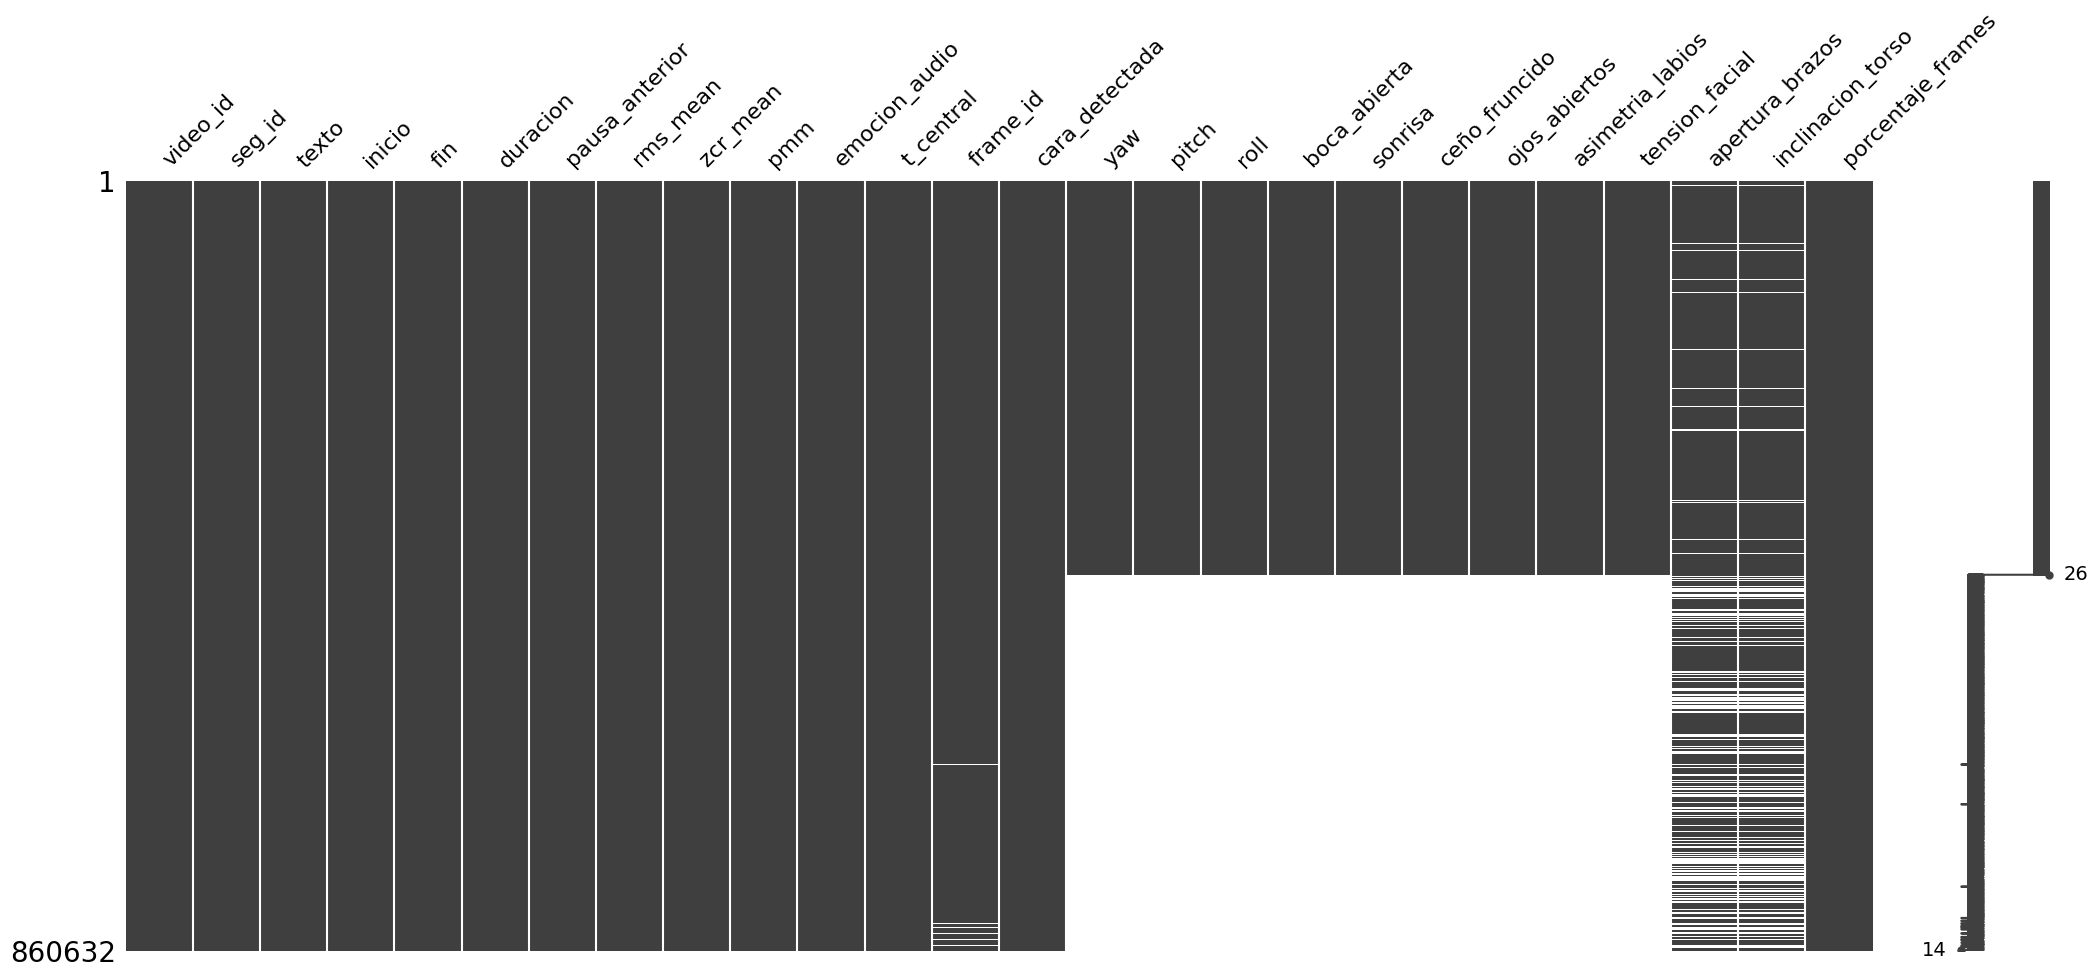

In [ ]:

import missingno as msno

# Plot correlation heatmap of missingness
msno.matrix(df_segmentos_win.sort_values(by='yaw'))

Se calcula el porcentaje de frames con cara_detectada = True para cada video_id, usando la media de valores booleanos.

Ese porcentaje se clasifica en 10 intervalos iguales (bins), de 0% a 100%.

Para cada vídeo se guarda el bin máximo alcanzado, indicando su nivel más alto de detección facial.

Finalmente, se muestra:

La distribución de vídeos según el bin de porcentaje de detección facial.

El número total de frames con y sin cara detectada.

In [ ]:
# Calcular porcentaje de frames con cara_detectada=True por video_id
porcentaje_cara_detectada = ( df_segmentos_win
                             .groupby("video_id")["cara_detectada"]
                              .transform(lambda x: x.mean() * 100) # mean de booleanos = proporción de True
                              )
# Clasificar en 10 intervalos iguales
df_segmentos_win["porcentaje_cara_detectada"] = pd.cut( porcentaje_cara_detectada, bins=10, labels=False )
# Resumen por video_id → la clase máxima
resumen1 = ( df_segmentos_win .groupby("video_id")["porcentaje_cara_detectada"]
            .max()
            .reset_index() )
print(resumen1["porcentaje_cara_detectada"].value_counts().sort_index())
print(df_segmentos_win["cara_detectada"].value_counts().sort_index())


porcentaje_cara_detectada
0    409
1    132
2    191
3    317
4    515
5    480
6    352
7    162
8     38
9     72
Name: count, dtype: int64
cara_detectada
False    420541
True     440091
Name: count, dtype: int64


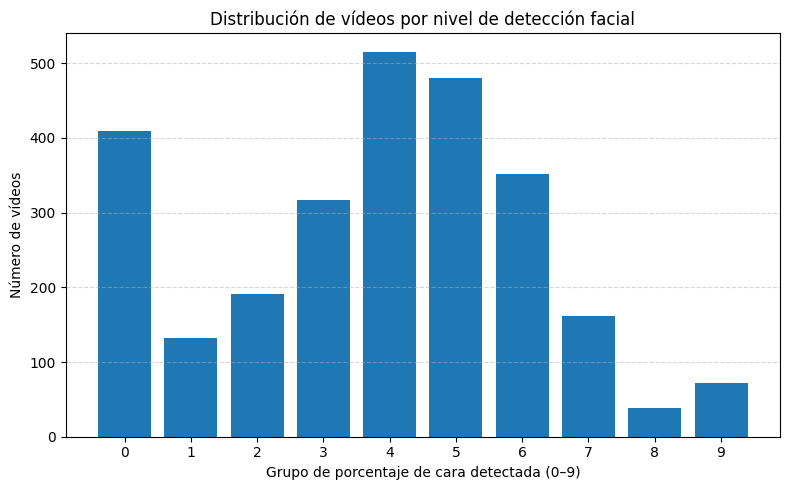

In [ ]:
import matplotlib.pyplot as plt

# Conteo de videos por grupo de porcentaje de cara detectada
conteo_por_grupo = resumen1["porcentaje_cara_detectada"].value_counts().sort_index()

# Gráfico de barras
plt.figure(figsize=(8,5))
plt.bar(conteo_por_grupo.index.astype(str), conteo_por_grupo.values)
plt.xlabel("Grupo de porcentaje de cara detectada (0–9)")
plt.ylabel("Número de vídeos")
plt.title("Distribución de vídeos por nivel de detección facial")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

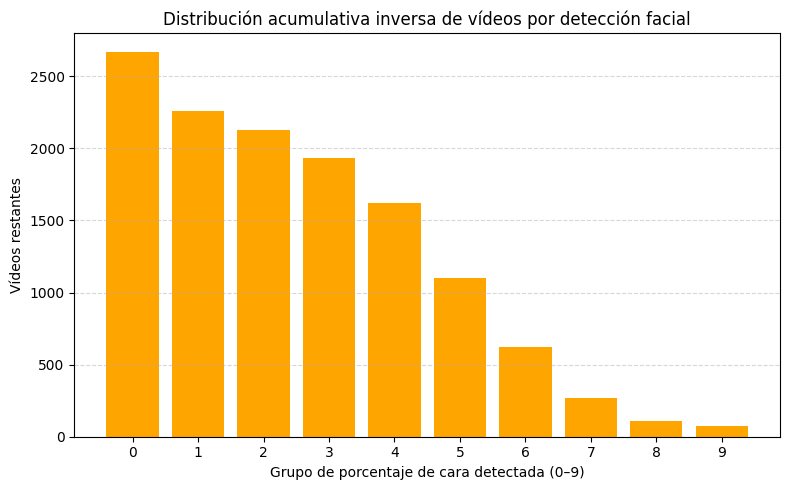

In [ ]:
# Conteo acumulado descendente por grupo
conteo_acumulado_desc = conteo_por_grupo[::-1].cumsum()[::-1]

plt.figure(figsize=(8,5))
plt.bar(conteo_acumulado_desc.index.astype(str), conteo_acumulado_desc.values, color='orange')
plt.xlabel("Grupo de porcentaje de cara detectada (0–9)")
plt.ylabel("Vídeos restantes")
plt.title("Distribución acumulativa inversa de vídeos por detección facial")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Como observamos si nos quedasemos con peliculas con un alto porcentaje de deteccíon de caras perderíamos informacion de demasiados videos.

Vamos a optar por quedarnos con los videos que tienen mas de 30% de "cara_detectada".
Opto por esta opción como balance entre no rellenar demasiados datos y no quedarnos con un dataset demasiado pequeño. Nos quedaremos finalmente con la información correspondiente a 1936 videos.

al eliminar estos tambien eliminaremos los que tienen nulos de frame_id

Nos quedaremos con el dato de cara detactada para cuando gestionemos los nulos, saber en que porcentage los hemos rellenado

In [ ]:
df_seg_win_filtrado=df_segmentos_win[df_segmentos_win['porcentaje_cara_detectada']>=3]

In [ ]:
df_seg_win_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 725896 entries, 0 to 860631
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   video_id                   725896 non-null  object 
 1   seg_id                     725896 non-null  int64  
 2   texto                      725896 non-null  object 
 3   inicio                     725896 non-null  float64
 4   fin                        725896 non-null  float64
 5   duracion                   725896 non-null  float64
 6   pausa_anterior             725896 non-null  float64
 7   rms_mean                   725896 non-null  float64
 8   zcr_mean                   725896 non-null  float64
 9   pmm                        725896 non-null  float64
 10  emocion_audio              725896 non-null  object 
 11  t_central                  725896 non-null  float64
 12  frame_id                   725896 non-null  float64
 13  cara_detectada             725896 

In [ ]:
len(df_seg_win_filtrado['video_id'].unique())

1936

Estrategia de imputación propuesta




Imputación por mediana de cada vídeo
  Para cada columna numérica, los valores faltantes se reemplazan con la

  Para cada columna numérica, los valores faltantes se reemplazan con la mediana calculada dentro de cada video_id.

  Este enfoque mantiene la coherencia interna de cada vídeo, evitando que los valores imputados se veImputación por mediana de cada segmento del discurso en cada vídeo



In [ ]:
# Copia del dataset filtrado
df_segmentos_mediana = df_seg_win_filtrado.copy()

# Columnas numéricas
num_cols = df_segmentos_mediana.select_dtypes(include=np.number).columns

# Imputar cada columna numérica con la mediana por video_id
df_segmentos_mediana[num_cols] = (
    df_segmentos_mediana
    .groupby("video_id")[num_cols]
    .transform(lambda x: x.fillna(x.median()))
)

df_segmentos_mediana.info()

<class 'pandas.core.frame.DataFrame'>
Index: 725896 entries, 0 to 860631
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   video_id                   725896 non-null  object 
 1   seg_id                     725896 non-null  int64  
 2   texto                      725896 non-null  object 
 3   inicio                     725896 non-null  float64
 4   fin                        725896 non-null  float64
 5   duracion                   725896 non-null  float64
 6   pausa_anterior             725896 non-null  float64
 7   rms_mean                   725896 non-null  float64
 8   zcr_mean                   725896 non-null  float64
 9   pmm                        725896 non-null  float64
 10  emocion_audio              725896 non-null  object 
 11  t_central                  725896 non-null  float64
 12  frame_id                   725896 non-null  float64
 13  cara_detectada             725896 

Despues de imputar medianas por video observo que seguimos teniendo nan. Reviso y corresponde a 3 videos que finalmente elimino.

In [ ]:
df_con_nan = df_segmentos_mediana[df_segmentos_mediana.isna().any(axis=1)]

# Revisar cuántas filas tienen NaN
print(f"Número de videos con NaN: {len(df_con_nan['video_id'].unique())}")

Número de videos con NaN: 3


In [ ]:
#eliminamos esos 3 videos
df_segmentos_mediana = df_segmentos_mediana[~df_segmentos_mediana['video_id'].isin(df_con_nan['video_id'].unique())]
df_segmentos_mediana.info()

<class 'pandas.core.frame.DataFrame'>
Index: 722080 entries, 0 to 860631
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   video_id                   722080 non-null  object 
 1   seg_id                     722080 non-null  int64  
 2   texto                      722080 non-null  object 
 3   inicio                     722080 non-null  float64
 4   fin                        722080 non-null  float64
 5   duracion                   722080 non-null  float64
 6   pausa_anterior             722080 non-null  float64
 7   rms_mean                   722080 non-null  float64
 8   zcr_mean                   722080 non-null  float64
 9   pmm                        722080 non-null  float64
 10  emocion_audio              722080 non-null  object 
 11  t_central                  722080 non-null  float64
 12  frame_id                   722080 non-null  float64
 13  cara_detectada             722080 

Guardamos el archivo como "df_seg_win_med.csv"

In [ ]:
#guardamos
df_segmentos_mediana.to_csv(os.path.join(folder_path, "df_seg_win_med.csv"), index=False)
print("✅ Dataset con imputación por mediana de cada video guardado")

✅ Dataset con imputación por mediana de cada video guardado


## Unificación de la información entre datasets
Tras el proceso de limpieza y filtrado, quedaron definidos dos datasets principales:


*   Un dataset a nivel de vídeo, con información general por video_id.
*   Un dataset a nivel de segmento, con información detallada por fragmento del discurso.

Para asegurar la consistencia entre ambos, se procedió a eliminar del dataset de vídeos aquellos video_id que ya no estaban presentes en el dataset de segmentos, como consecuencia del filtrado y la imputación aplicados previamente.

El punto de partida para esta integración fue el conjunto de 1.933 vídeos con datos completos a nivel de segmento, resultado final de la limpieza detallada en los apartados anteriores.

A continuación, se revisó la variable idioma, presente en el dataset de vídeos. De los 1.933 vídeos disponibles, se decidió conservar únicamente aquellos en inglés (1.819 vídeos) y castellano (23 vídeos), descartando otros idiomas con escasa representación. Esta decisión se tomó para facilitar los análisis lingüísticos y de contenido textual.

El conjunto final quedó compuesto por 1.852 vídeos con datos consistentes tanto a nivel global como segmentado, distribuidos de la siguiente forma según su clase:

*   955 vídeos de tipo comunicador 0 (baja calidad comunicativa)
*   897 vídeos de tipo comunicador 1 (alta calidad comunicativa)

In [ ]:
df_videos=pd.read_csv(os.path.join(folder_path, "df_videos_analizados.csv"))
df_seg_win_med=pd.read_csv(os.path.join(folder_path, "df_seg_win_med.csv"))

# Forzar video_id como string en ambos DataFrames
df_videos['video_id'] = df_videos['video_id'].astype(str)
df_seg_win_med['video_id'] = df_seg_win_med['video_id'].astype(str)

df_videos_filtrado = df_videos[df_videos['video_id'].isin(df_seg_win_med['video_id'].unique())]


# Número de videos únicos en df_segmentos_filtrado
num_videos_segmentos = df_seg_win_med['video_id'].nunique()

# Número de videos únicos después del merge
num_filas = len(df_videos_filtrado)

# Conteo de idiomas en los videos filtrados
idioma_counts = df_videos_filtrado['idioma'].value_counts()

print(f"Número de video_id únicos en df_segmentos_mediana: {num_videos_segmentos}")
print(f"Número de video_id únicos después del merge: {num_filas}")
print("Conteo de idiomas en df_videos_filtrado:")
print(idioma_counts)


/tmp/ipython-input-3775817393.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_seg_win_med=pd.read_csv(os.path.join(folder_path, "df_seg_win_med.csv"))


Número de video_id únicos en df_segmentos_mediana: 1933
Número de video_id únicos después del merge: 1933
Conteo de idiomas en df_videos_filtrado:
idioma
en    1819
cy      36
es      33
fr      12
ms       4
zh       4
sv       3
sw       3
gl       3
ja       2
ko       2
hi       2
it       2
fi       1
he       1
no       1
pt       1
el       1
sl       1
la       1
mi       1
Name: count, dtype: int64


In [ ]:
#revisamos si solo nos quedasemos con los videos de ingles y castellano, como quedaría el balanceo de tipo_comunicador
print(df_videos_filtrado[(df_videos_filtrado["idioma"]=="en") | (df_videos_filtrado["idioma"]=="es")]["tipo_comunicador"].value_counts())

tipo_comunicador
0    955
1    897
Name: count, dtype: int64


In [ ]:
#decidimos quedarnos solo con los videos en ingles y en castellano
df_videos_filtrado=df_videos_filtrado[(df_videos_filtrado["idioma"]=="en") | (df_videos_filtrado["idioma"]=="es")]
#corregimos ya tb los segmentos a los mismos vide_id
df_seg_win_med = df_seg_win_med[df_seg_win_med['video_id'].isin(df_videos_filtrado['video_id'].unique())]
#verificamos
df_no_encontrados = df_videos_filtrado[~df_videos_filtrado['video_id'].isin(df_seg_win_med['video_id'].unique())]
df_no_encontrados1 = df_seg_win_med[~df_seg_win_med['video_id'].isin(df_videos_filtrado['video_id'].unique())]
print(len(df_no_encontrados))
print(len(df_no_encontrados1))

0
0


In [ ]:
df_seg_win_med.info()

<class 'pandas.core.frame.DataFrame'>
Index: 693662 entries, 0 to 722079
Data columns (total 27 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   video_id                   693662 non-null  object 
 1   seg_id                     693662 non-null  int64  
 2   texto                      693662 non-null  object 
 3   inicio                     693662 non-null  float64
 4   fin                        693662 non-null  float64
 5   duracion                   693662 non-null  float64
 6   pausa_anterior             693662 non-null  float64
 7   rms_mean                   693662 non-null  float64
 8   zcr_mean                   693662 non-null  float64
 9   pmm                        693662 non-null  float64
 10  emocion_audio              693662 non-null  object 
 11  t_central                  693662 non-null  float64
 12  frame_id                   693662 non-null  float64
 13  cara_detectada             693662 

In [ ]:
df_videos_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852 entries, 0 to 2668
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   video_id          1852 non-null   object 
 1   link              1852 non-null   object 
 2   tipo_comunicador  1852 non-null   int64  
 3   grupo             1852 non-null   int64  
 4   duracion_video    1852 non-null   float64
 5   texto_completo    1852 non-null   object 
 6   idioma            1852 non-null   object 
dtypes: float64(1), int64(2), object(4)
memory usage: 115.8+ KB


calculamos datos por video

# 3.4 Cálculo de características adicionales
Con el objetivo de enriquecer la representación de cada discurso y facilitar el entrenamiento de modelos explicativos, se calcularon características adicionales tanto a nivel de vídeo como a partir de la agregación de variables por segmento. Estas características complementan la información multimodal previamente extraída, incorporando medidas de claridad, impacto, expresividad y patrones discursivos.

## Análisis textual avanzado sobre discursos completos

Este bloque de código realiza el cálculo de características textuales agregadas a nivel de vídeo, utilizando modelos de embeddings multilingües y funciones lingüísticas manuales. Las variables generadas tienen como objetivo cuantificar aspectos clave del discurso como su claridad, impacto emocional y uso narrativo.

Componentes del análisis:

Carga de modelo de embeddings

Se utiliza paraphrase-multilingual-MiniLM-L12-v2 de sentence-transformers, que permite trabajar tanto con discursos en español como en inglés.

Definición de patrones lingüísticos clave

Listas de palabras y frases indicadoras de:

Muletillas

Anecdotas personales

Ejemplos explicativos

Palabras de impacto o poder (power words)

Cálculo de métricas de claridad

Mediante una adaptación de la fórmula de Flesch (español/inglés).

Se computa también el número total de oraciones (claridad_oraciones).

Cálculo de métricas de impacto

Número de palabras de alto impacto emocional o persuasivo.

Presencia de marcadores anecdóticos (yo, nosotros, i, we, etc.).

Detección de ejemplos mediante expresiones como “por ejemplo” o “for example”.

Detección de patrones narrativos vía embeddings

Se codifican las oraciones del discurso y se calcula la similitud con frases semilla representativas de:

Anecdotas (indicadores_anecdota)

Ejemplos (conectores_ejemplo)

Se incluye la detección aproximada por similitud semántica (cos_sim) con umbral ≥ 0.6.

Salida final del análisis

Para cada vídeo se generan nuevas columnas:

claridad_oraciones

impacto_palabras_poder

impacto_anecdotas_detectadas

anecdotas (totales detectadas)

ejemplos (totales detectados)

Estas variables se almacenan en df_videos_caract_texto, y posteriormente se integrarán al dataset final que se utilizará para el modelado.

In [ ]:
from sentence_transformers import SentenceTransformer, util
import nltk
import pandas as pd
import re

# -----------------------------
# Configuración inicial
# -----------------------------
nltk.download("punkt_tab")

model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# -----------------------------
# Patrones lingüísticos
# -----------------------------
muletillas = {
    "es": ["eh", "este", "o sea", "vale", "bueno", "ehm"],
    "en": ["um", "uh", "like", "you know", "so", "well"]
}

indicadores_anecdota = {
    "es": ["una vez", "recuerdo que", "me pasó", "cuando", "estaba", "fui", "tenía", "en mi vida"],
    "en": ["once", "i remember", "it happened", "when", "i was", "i went", "i had"]
}

conectores_ejemplo = {
    "es": ["por ejemplo", "como", "tal como", "a modo de ejemplo", "imagina que", "supongamos que"],
    "en": ["for example", "such as", "like", "as an example", "imagine that", "suppose that"]
}

# Para el impacto
PODER_ES = ["clave", "crítico", "potente", "nuevo", "probado", "garantiza", "impulsa", "mejora",
            "transforma", "aumenta", "reduce", "rápido", "fácil", "eficaz", "evidencia", "récord",
            "resultados", "ahora", "demostrado"]
POWER_EN = ["key", "critical", "powerful", "new", "proven", "guaranteed", "boost", "improves",
            "transforms", "increases", "reduces", "fast", "easy", "effective", "evidence",
            "record", "results", "now", "demonstrated"]

VOWELS = set("aeiouáéíóúüAEIOUÁÉÍÓÚÜ")

# -----------------------------
# Tokenización
# -----------------------------
def split_sentences(text: str):
    text = re.sub(r"\s+", " ", text.strip())
    parts = re.split(r"(?<=[.!?¿¡])\s+", text)
    return [p.strip() for p in parts if p.strip()]

def split_words(text: str):
    return re.findall(r"[\wÁÉÍÓÚÜáéíóúüñÑ'-]+", text, flags=re.UNICODE)

# -----------------------------
# Métricas de claridad e impacto
# -----------------------------
def count_syllables(word: str):
    groups = 0
    prev = False
    for ch in word:
        is_v = ch in VOWELS
        if is_v and not prev:
            groups += 1
        prev = is_v
    return max(1, groups)

def flesch_es(text: str):
    sents = split_sentences(text)
    words = split_words(text)
    if not sents or not words:
        return 0.0
    syllables = sum(count_syllables(w) for w in words)
    spw = syllables / len(words)
    wps = len(words) / len(sents)
    return 206.84 - 62.3 * spw - wps

def flesch_en(text: str):
    sents = split_sentences(text)
    words = split_words(text)
    if not sents or not words:
        return 0.0
    syllables = sum(count_syllables(w) for w in words)
    spw = syllables / len(words)
    wps = len(words) / len(sents)
    return 206.835 - 1.015 * wps - 84.6 * spw

def score_clarity(text: str, lang: str):
    sents = split_sentences(text)
    readability = flesch_es(text) if lang=="es" else flesch_en(text)
    return {"oraciones": len(sents), "readability": readability}

def score_impact(text: str, lang: str):
    words = split_words(text)
    power = PODER_ES if lang=="es" else POWER_EN
    n_poder = sum(1 for w in words if w.lower() in power)
    anecdote_markers = ["yo","mi","nosotros","nuestro"] if lang=="es" else ["i","my","we","our"]
    anecdote_hits = sum(1 for w in words if w.lower() in anecdote_markers)
    example_hits = len(re.findall(r"por ejemplo", text, re.IGNORECASE)) if lang=="es" else len(re.findall(r"for example", text, re.IGNORECASE))
    return {"palabras_poder": n_poder, "anecdotas_detectadas": anecdote_hits, "ejemplos_detectados": example_hits}

# -----------------------------
# Funciones de análisis tipo embeddings
# -----------------------------
def contar_muletillas(oraciones, patrones):
    count = 0
    total = 0
    for o in oraciones:
        total += len(o.split())
        for p in patrones:
            if len(p) <= 3:
                regex = r"\b" + re.escape(p) + r"+\b"
            else:
                regex = r"\b" + re.escape(p) + r"\b"
            if re.search(regex, o.lower()):
                count += 1
    return count / total if total > 0 else 0

def contar_frases(oraciones, lista_patrones):
    return sum(any(p in o.lower() for p in lista_patrones) for o in oraciones)

def detectar_por_embeddings(oraciones_emb, seed_patterns, threshold=0.6):
    if oraciones_emb.shape[0] == 0:
        return 0
    seeds_emb = model.encode(seed_patterns, convert_to_tensor=True)
    sims = util.cos_sim(oraciones_emb, seeds_emb)
    return sum((sims.max(dim=1).values > threshold).cpu().numpy())

# -----------------------------
# Función unificada de análisis
# -----------------------------
def analizar_video(row):
    texto = row['texto_completo']
    idioma = row.get('idioma', None)
    if not idioma:
        # detectar idioma
        words = [w.lower() for w in split_words(texto)]
        es_hits = sum(1 for w in words if w in set("""y de la que el en los se del las un por con no una su para es al lo como más o pero sus le ya o u e si porque muy sin sobre también me hasta hay donde quien desde todo nos durante todos uno les ni contra otros ese eso ante ellos e esto mi antes algunos qué unos yo otro otras otra él tanto esa estos mucho quienes nada muchos cual cuales sea poco ella estar estas algún cómo dos haber aquí mío tuyo suyo nuestra nuestras vuestro vuestros quién cuándo cuáles cuál cuál es son fue eran sería sería serán ser estar estoy estás está estamos están estaban estuvieron estará estaría fui fuiste fue fuimos fueron será serán""".split()))
        en_hits = sum(1 for w in words if w in set("""the of and to in a is that it for on you with as at this but by from they we be have not are or an was if can all will your which their more one about when so what there use up said do out who get she he them his her into than some could been just like now only its also then may our should after over such where how new other these see two first any because me my would did has those before being having""".split()))
        idioma = "es" if es_hits >= en_hits else "en"

    oraciones = split_sentences(texto)
    oraciones_emb = model.encode(oraciones, convert_to_tensor=True) if oraciones else None

    # Métricas de embeddings
    num_anecdotas = (
        contar_frases(oraciones, indicadores_anecdota[idioma]) +
        (detectar_por_embeddings(oraciones_emb, indicadores_anecdota[idioma]) if oraciones_emb is not None else 0)
    )
    num_ejemplos = (
        contar_frases(oraciones, conectores_ejemplo[idioma]) +
        (detectar_por_embeddings(oraciones_emb, conectores_ejemplo[idioma]) if oraciones_emb is not None else 0)
    )

    # Métricas de claridad e impacto
    c = score_clarity(texto, idioma)
    i = score_impact(texto, idioma)



    return pd.Series({
        "claridad_oraciones": c["oraciones"],
        "impacto_palabras_poder": i["palabras_poder"],
        "impacto_anecdotas_detectadas": i["anecdotas_detectadas"],
        "anecdotas": num_anecdotas,
        "ejemplos": num_ejemplos


    })

# -----------------------------
# Aplicar al DataFrame
# -----------------------------
df_result = df_videos_filtrado.apply(analizar_video, axis=1)
df_videos_caract_texto = pd.concat([df_videos_filtrado, df_result], axis=1)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
df_videos_caract_texto.to_csv(os.path.join(folder_path, "df_videos_caract_texto.csv"), index=False)
print("✅ Dataset con informacion adicional de texto de cada video guardado")


✅ Dataset con informacion adicional de texto de cada video guardado


In [ ]:
df_videos_caract_texto.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1852 entries, 0 to 2668
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   video_id                      1852 non-null   object 
 1   link                          1852 non-null   object 
 2   tipo_comunicador              1852 non-null   int64  
 3   grupo                         1852 non-null   int64  
 4   duracion_video                1852 non-null   float64
 5   texto_completo                1852 non-null   object 
 6   idioma                        1852 non-null   object 
 7   claridad_oraciones            1852 non-null   int64  
 8   impacto_palabras_poder        1852 non-null   int64  
 9   impacto_anecdotas_detectadas  1852 non-null   int64  
 10  anecdotas                     1852 non-null   int64  
 11  ejemplos                      1852 non-null   int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 188.1+ KB


Análisis de correlaciones entre características textuales y calidad comunicativa

Como paso final del análisis textual, se realizó un estudio de correlación entre las variables textuales generadas y la clase objetivo (tipo_comunicador), con el fin de identificar qué métricas pueden estar asociadas a una mayor o menor calidad comunicativa percibida.

Procedimiento:

Se calcularon los coeficientes de correlación de Pearson entre las variables numéricas textuales y la clase objetivo.

Se aplicó un umbral mínimo de correlación (|r| ≥ 0.06) para seleccionar únicamente aquellas variables con mayor potencial discriminativo.

A continuación, se representaron gráficamente las variables seleccionadas:

Boxplots para visualizar su distribución según el tipo de comunicador.

Pairplot para observar relaciones cruzadas entre ellas.

Mapa de calor (heatmap) para ver la matriz de correlación completa.

Este análisis exploratorio permite detectar patrones potenciales útiles para el modelado posterior y sirve como base para la selección de variables predictoras.

Columnas importantes: ['duracion_video', 'claridad_oraciones', 'impacto_palabras_poder', 'impacto_anecdotas_detectadas', 'anecdotas', 'ejemplos']


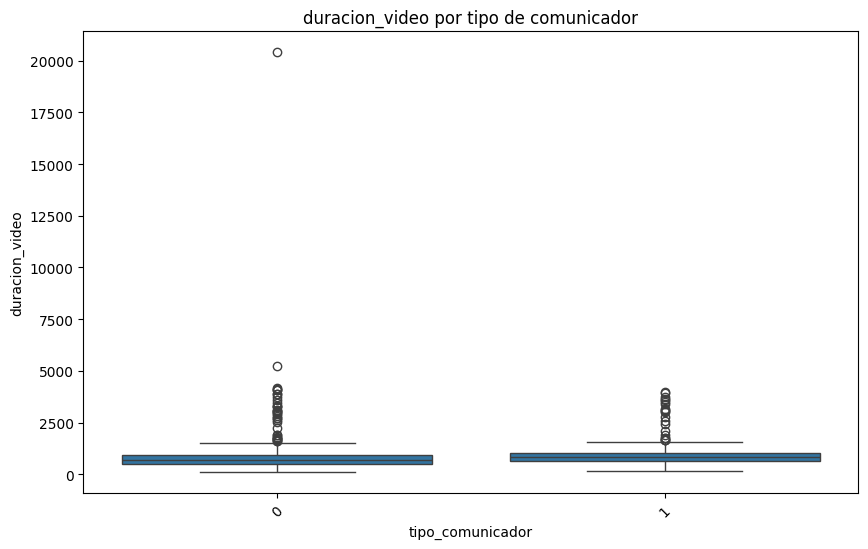

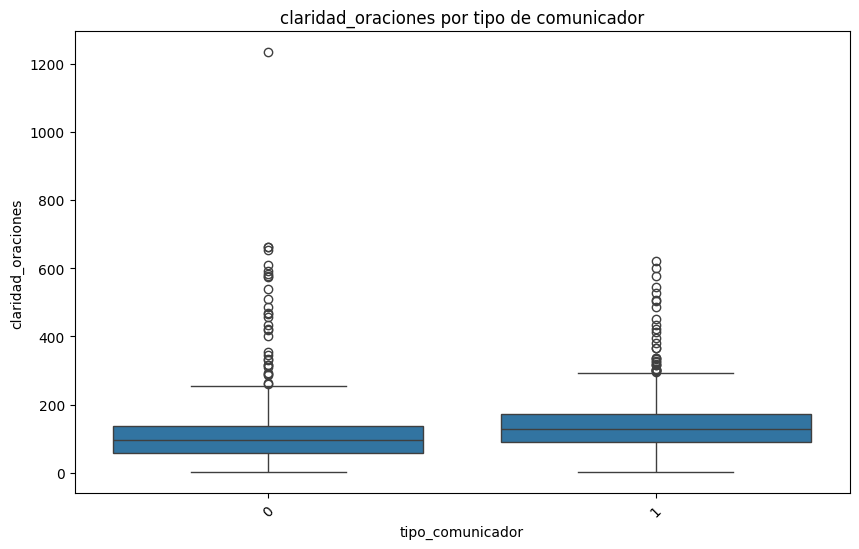

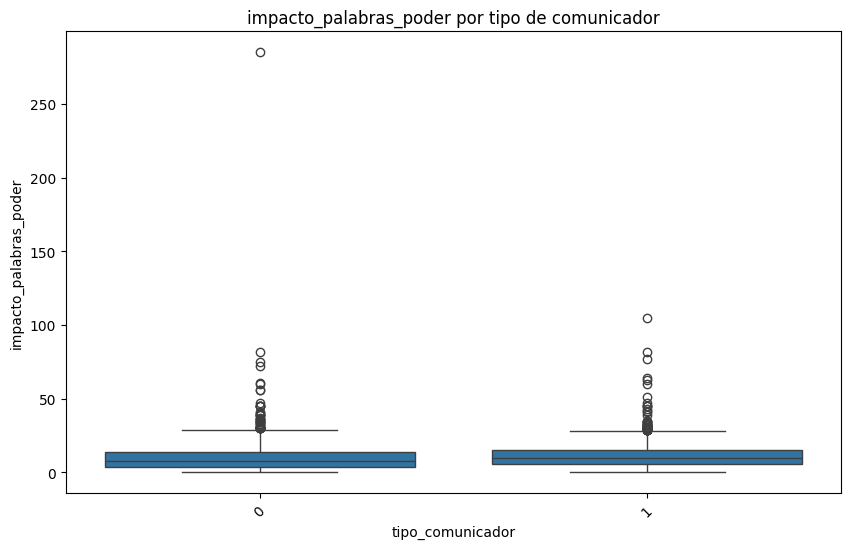

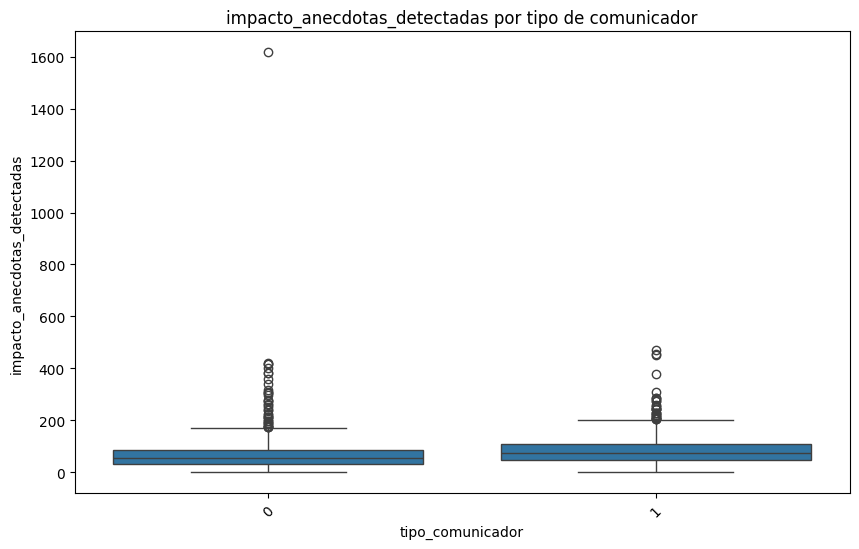

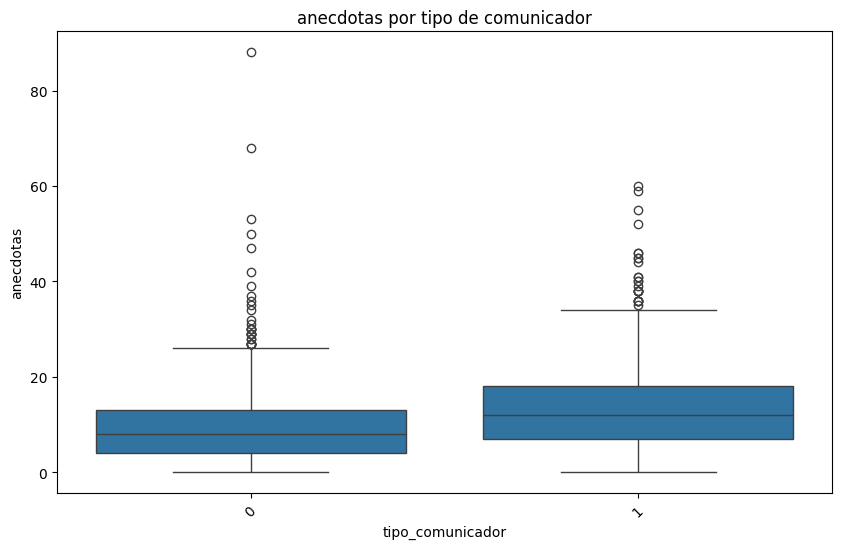

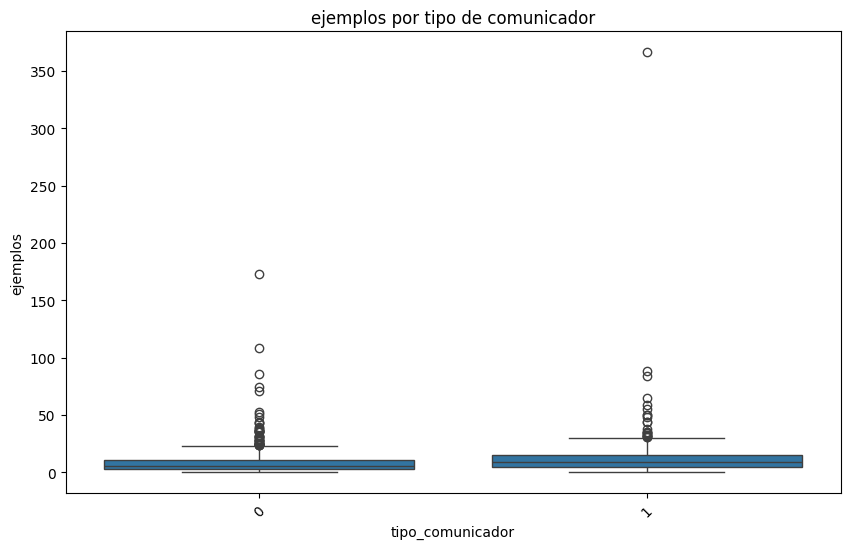

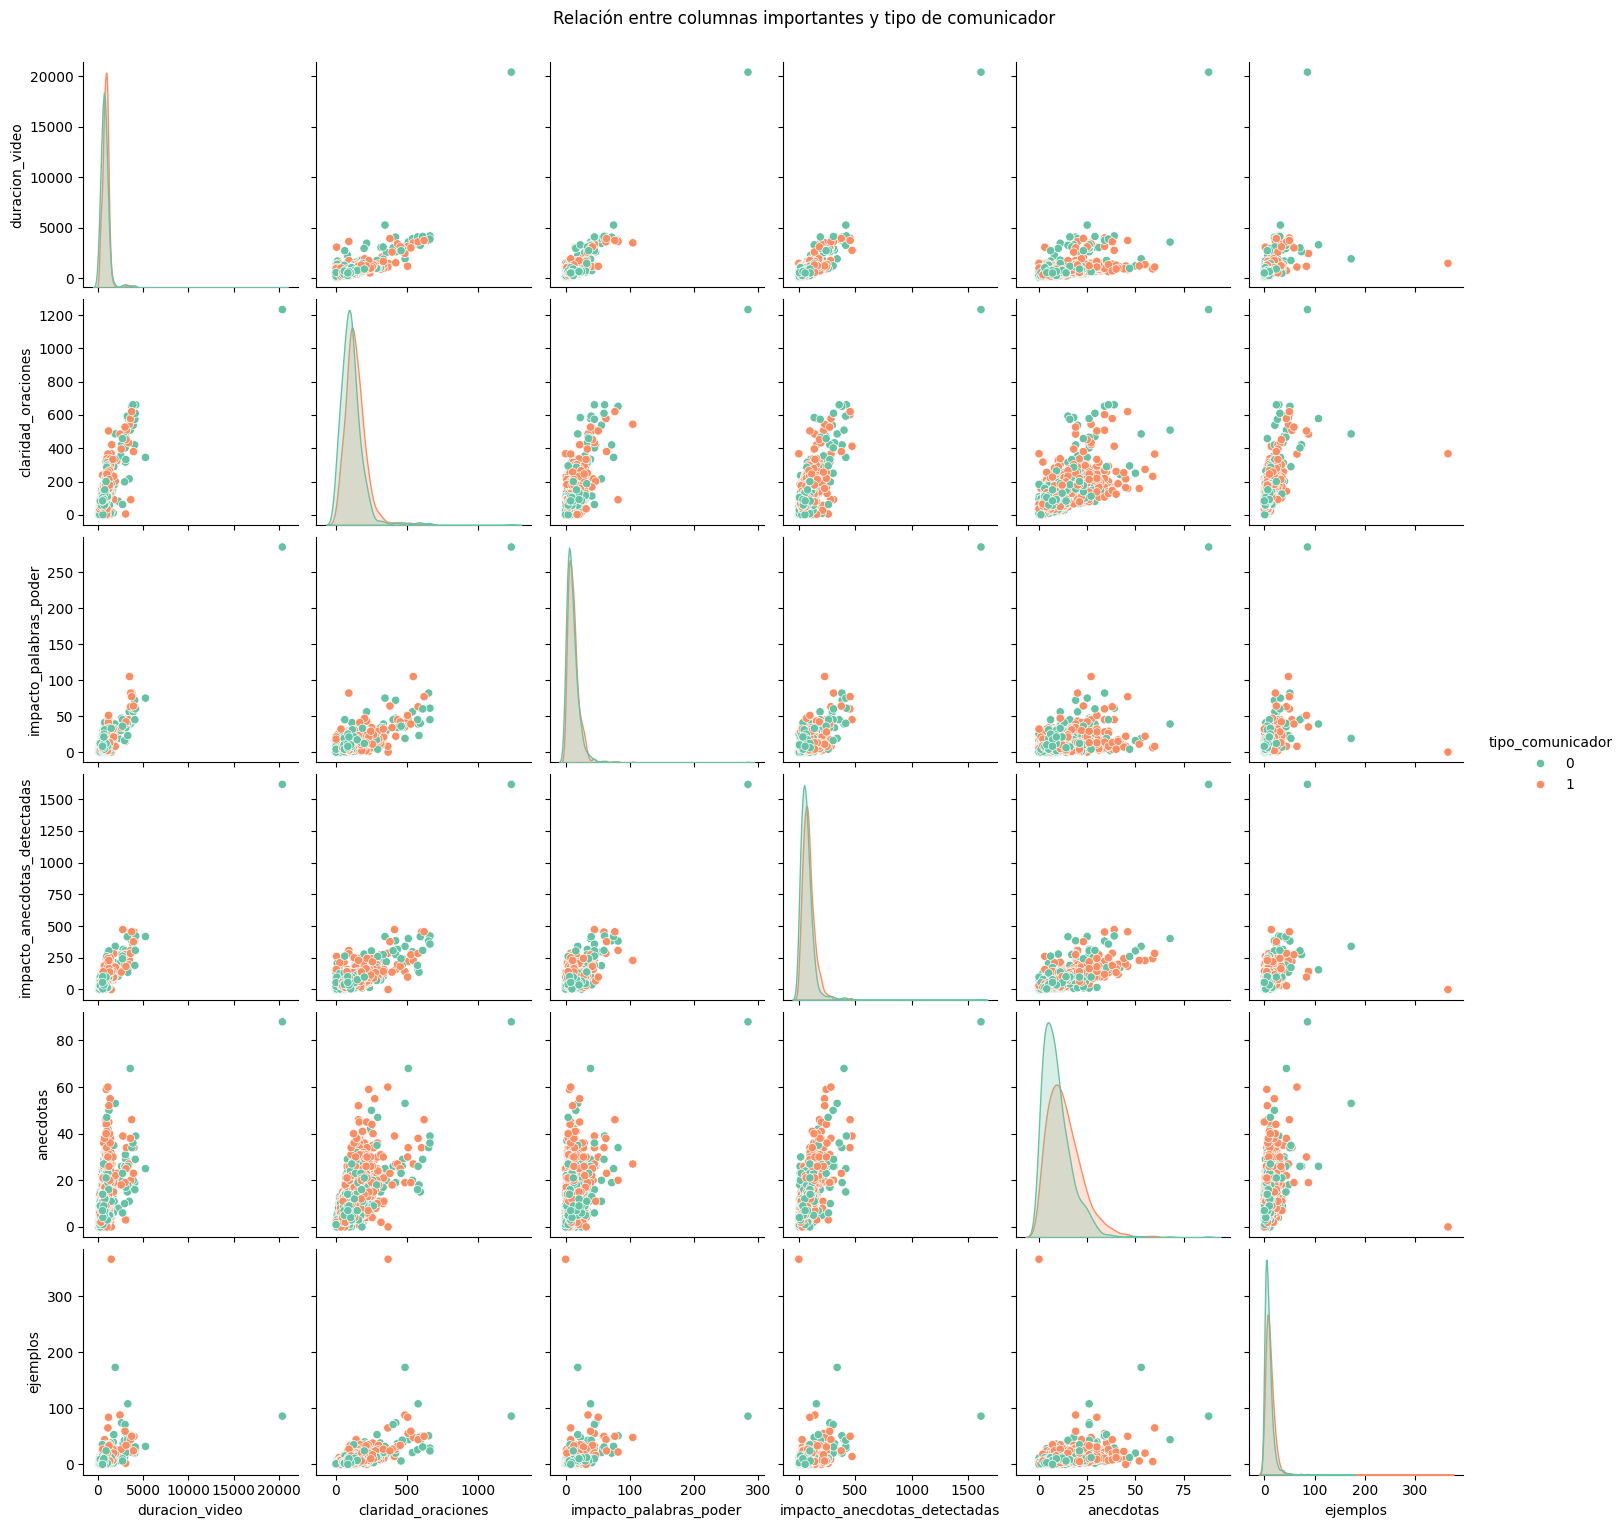

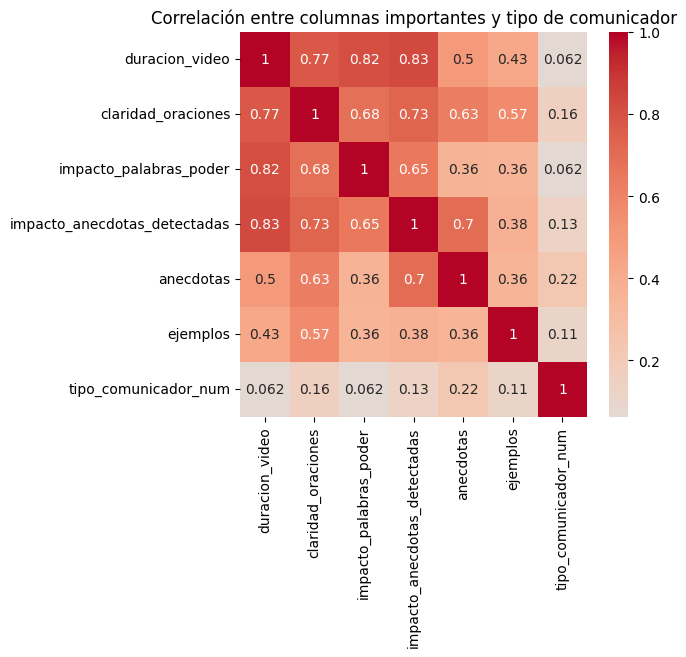

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# --- columnas a excluir ---
exclude_cols = ['video_id','link','tipo_comunicador','texto_completo','idioma','tipo_comunicador_num']

# --- columnas numéricas restantes ---
cols = [c for c in df_videos_caract_texto.select_dtypes(include=['number']).columns if c not in exclude_cols]

# --- crear columna numérica del target ---
encoder = LabelEncoder()
df_videos_caract_texto["tipo_comunicador_num"] = encoder.fit_transform(df_videos_caract_texto["tipo_comunicador"])

# --- calcular correlación con el target ---
corr_target = df_videos_caract_texto[cols + ["tipo_comunicador_num"]].corr()["tipo_comunicador_num"].drop("tipo_comunicador_num")

# --- seleccionar solo las columnas con correlación por encima de un umbral ---
umbral = 0.06 # ajustar según necesidad
cols_importantes = corr_target[abs(corr_target) >= umbral].index.tolist()
print("Columnas importantes:", cols_importantes)

# --- guardar la lista para usar después ---
lista_cols_importantes = cols_importantes.copy()

# 1. Boxplots para columnas importantes
for col in lista_cols_importantes:
    plt.figure(figsize=(10,6))
    sns.boxplot(data=df_videos_caract_texto, x="tipo_comunicador", y=col)
    plt.title(f"{col} por tipo de comunicador")
    plt.xticks(rotation=45)
    plt.show()

# 2. Matriz de dispersión (pairplot)
if len(lista_cols_importantes) > 1:
    sns.pairplot(df_videos_caract_texto, vars=lista_cols_importantes, hue="tipo_comunicador", palette="Set2")
    plt.suptitle("Relación entre columnas importantes y tipo de comunicador", y=1.02)
    plt.show()



# 3. Heatmap de correlación
plt.figure(figsize=(len(lista_cols_importantes)*0.6+2, 5))
sns.heatmap(df_videos_caract_texto[lista_cols_importantes + ["tipo_comunicador_num"]].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlación entre columnas importantes y tipo de comunicador")
plt.show()

In [ ]:
lista_evaluar=lista_cols_importantes+['tipo_comunicador','video_id']
df_eval_final=df_videos_caract_texto[lista_evaluar].copy()
df_eval_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1852 entries, 0 to 2668
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   duracion_video                1852 non-null   float64
 1   claridad_oraciones            1852 non-null   int64  
 2   impacto_palabras_poder        1852 non-null   int64  
 3   impacto_anecdotas_detectadas  1852 non-null   int64  
 4   anecdotas                     1852 non-null   int64  
 5   ejemplos                      1852 non-null   int64  
 6   tipo_comunicador              1852 non-null   int64  
 7   video_id                      1852 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 130.2+ KB


## Cálculo de características agregadas y derivadas a nivel de vídeo

En esta sección se realiza la consolidación de características a nivel de vídeo a partir del dataset segmentado. El objetivo es generar un conjunto de variables agregadas y nuevas métricas combinadas que capturen el comportamiento global del orador durante su discurso.

1. Codificación de *emociones* y detección de énfasis

Se aplica One-Hot Encoding sobre la variable emocion_audio, generando columnas binarias por cada emoción detectada.

Se calcula una nueva variable enfasis, que marca los segmentos con alta energía (rms ≥ percentil 75 por vídeo) y una pausa anterior ≥ 1.5 s. Esto permite identificar momentos con mayor carga expresiva.

2. Selección de variables y agregación por vídeo

Se seleccionan variables acústicas, visuales y emocionales relevantes por segmento.

Para cada vídeo, se calculan estadísticas agregadas sobre esas variables:

Media (mean)

Varianza (var)

Máximo (max)

Mínimo (min)

Esto genera un perfil global del comportamiento del orador en términos de ritmo, gestos, expresividad facial, etc.

3. Ingeniería de características combinadas

Se crean nuevas variables a partir de combinaciones inteligentes de características existentes, como:

rms_sonrisa: combinación entre energía y sonrisa → expresa entusiasmo.

pitch_ojos: combinación entre tono y apertura ocular → atención o sorpresa.

zcr_ceño: relación entre sonoridad y tensión facial → indicios de estrés.

Ratios y diferencias que reflejan contrastes y dinámicas expresivas (rms_zcr_var_ratio, boca_apertura_diff, etc.).

4. Índice de expresividad global

Se construye una métrica compuesta que sintetiza el nivel de expresividad del orador combinando:

Expresividad gestual: movimientos de cabeza (yaw, pitch, roll).

Expresividad facial: intensidad media de rasgos como sonrisa, ceño, apertura ocular y tensión.

El índice final se calcula como:

expresividad = 0.4 * expresividad_gestual + 0.6 * expresividad_facial


Este valor resume el grado en que el orador usa su cuerpo y rostro para acompañar el mensaje verbal.

5. Generación del dataset final para modelado

El dataset df_videos resultante contiene una fila por vídeo con todas las variables agregadas y derivadas.

Se fusiona con df_eval_final para añadir la etiqueta y otras variables contextuales.

Se guarda como archivo CSV bajo el nombre: df_model.csv.

In [ ]:
import pandas as pd
df_dummies = pd.get_dummies(df_seg_win_med, columns=['emocion_audio'])
df_dummies.to_csv(os.path.join(folder_path, "df_dummies.csv"), index=False)

In [ ]:
df_segmentos = df_dummies.copy()

limite_enfasis = (
    df_segmentos
    .groupby("video_id")["rms_mean"]
    .transform(lambda x: x.quantile(0.75) if x.notnull().any() else 0)
)


df_segmentos["enfasis"] = (
    (df_segmentos["rms_mean"] >= limite_enfasis) &
    (df_segmentos["pausa_anterior"] >= 1.5)
).astype(int)

In [ ]:
df_segmentos['enfasis'].value_counts()

,count
enfasis,
0,680090
1,13572


In [ ]:
import pandas as pd
import numpy as np




# -------------------------
# 1. Columnas de segmento
# -------------------------
segment_features = [
    'pausa_anterior','enfasis','rms_mean', 'zcr_mean', 'pmm','yaw', 'pitch', 'roll',
    'boca_abierta', 'sonrisa', 'ceño_fruncido', 'ojos_abiertos', 'asimetria_labios',
    'tension_facial', 'apertura_brazos', 'inclinacion_torso',
    'emocion_audio_angry', 'emocion_audio_calm', 'emocion_audio_disgust',
    'emocion_audio_fearful', 'emocion_audio_happy', 'emocion_audio_neutral',
    'emocion_audio_sad', 'emocion_audio_surprised','porcentaje_cara_detectada'
]

# -------------------------
# 2. Estadísticas agregadas por video
# -------------------------
agg_funcs = ['mean', 'var', 'max', 'min']
df_videos = df_segmentos.groupby('video_id')[segment_features].agg(agg_funcs)

# Aplanar MultiIndex
df_videos.columns = ['_'.join(col).strip() for col in df_videos.columns.values]

# Añadir etiqueta de tipo de comunicador
labels = df_segmentos.groupby('video_id').first()
df_videos.reset_index(inplace=True)

# -------------------------
# 3. Feature engineering: combinaciones inteligentes
# -------------------------
df_videos['rms_sonrisa'] = df_videos['rms_mean_mean'] * df_videos['sonrisa_mean']
df_videos['pitch_ojos'] = df_videos['pitch_mean'] * df_videos['ojos_abiertos_mean']
df_videos['zcr_ceño'] = df_videos['zcr_mean_mean'] * df_videos['ceño_fruncido_mean']

df_videos['rms_brazos'] = df_videos['rms_mean_mean'] * df_videos['apertura_brazos_mean']
df_videos['pitch_torso'] = df_videos['pitch_mean'] * df_videos['inclinacion_torso_mean']

df_videos['rms_zcr_var_ratio'] = df_videos['rms_mean_var'] / (df_videos['zcr_mean_var'] + 1e-6)
df_videos['boca_apertura_diff'] = df_videos['boca_abierta_mean'] - np.sqrt(df_videos['boca_abierta_var'] + 1e-6)

# -------------------------
# 4. Medida de expresividad
# -------------------------
# Parámetro de mezcla: 40% gestual, 60% facial
alpha = 0.4

# Expresividad gestual (movimientos de cabeza)
df_videos['expresividad_gestual'] = np.sqrt(
    df_videos['yaw_mean']**2 + df_videos['pitch_mean']**2 + df_videos['roll_mean']**2
)

# Expresividad facial (media de intensidades faciales)
df_videos['expresividad_facial'] = df_videos[[
    'boca_abierta_mean','sonrisa_mean','ceño_fruncido_mean',
    'ojos_abiertos_mean','asimetria_labios_mean','tension_facial_mean'
]].mean(axis=1)

# Índice global
df_videos['expresividad'] = alpha * df_videos['expresividad_gestual'] + (1-alpha) * df_videos['expresividad_facial']

# -------------------------
# 5. Guardar CSV final listo para modelo
# -------------------------
df_videos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1852 entries, 0 to 1851
Columns: 111 entries, video_id to expresividad
dtypes: bool(16), float64(90), int64(4), object(1)
memory usage: 1.4+ MB


In [ ]:
df_videos.to_csv(os.path.join(folder_path, "df_estadisticas_segmentos_video.csv"), index=False)

Guardamos el dataframe final con los datos en un unico datataframe llamado df_model.csv

In [ ]:
df_model=df_eval_final.merge(df_videos, on='video_id')
#guardamos una copia
df_model.to_csv(os.path.join(folder_path, "df_model.csv"), index=False)
print(df_model.isnull().any().any())

False
